# Linear Classifiers and SVM

> Weitong Zhang
> 2015011493
>
> <zwt15@mails.tsinghua.edu.cn>

## Programming

### Generate the Linearly Separable Data in 2-D space

According to the theory of Linear Classifier, we can conclude that the linear separable data could be described as the following function

$$\vec x = \vec x_p + r\frac{\vec w}{\|w\|}, sgn(r) = y_i$$

Therefore, in 2-D linear space, ANY linear separable data could be described as a linear transform$\vec x = \mathbf W \vec x_0 + \vec b, \vec x_0 = [a_1,a_2], sgn(a_1) = y_i, W = k\mathbf R$, where $k$ is the scaling parameter, $\mathbf R$ is the rotation matrix $\mathbf R = \begin{pmatrix} \cos\theta & \sin\theta \\ -\sin\theta & \cos\theta\end{pmatrix}, \vec b$ is the transforming vector

Therefore, we can generate the linearly separable data from the tranforming of half space, here, we set $k = const, \vec b = 0$ to simplify the generation (it is obvious that these two parameters will not strongly affected the distribution of samples.

In practice, we use the stochastic points method to generate the dataset 

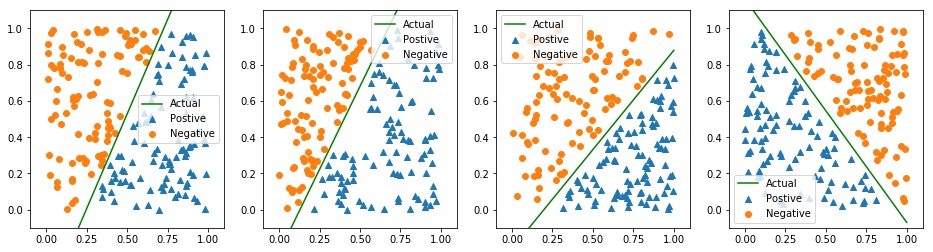

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

samples = 100
margin = 5e-2
plt.rcParams["figure.figsize"] = [16,4]

def gen_data():
    # Xa, Xb are on the seperating line
    Xa = np.random.rand(2)
    # generate Xb in the diagonal area
    if Xa[0] < 0.5 and Xa[1] < 0.5:
        lb1, lb2 = 0.5, 0.5
    elif Xa[0] < 0.5 and Xa[1] >= 0.5:
        lb1, lb2 = 0.5, 0
    elif Xa[0] >= 0.5 and Xa[1] < 0.5:
        lb1, lb2 = 0, 0.5
    else:
        lb1, lb2 = 0, 0
    Xb = np.array([lb + 0.5 * np.random.rand() for lb in (lb1, lb2)])
    
    # the separating line: x2 = k * x1 + b
    k = (Xa[1] - Xb[1]) / (Xa[0] - Xb[0])
    b = Xa[1] - k * Xa[0]
    
    # generate the samples
    X_pos = np.zeros((2, samples))
    X_neg = np.zeros((2, samples))
    
    def is_positive(x):
        return k * x[0] + b > x[1] + margin
    
    def is_negative(x):
        return k * x[0] + b < x[1] - margin
    
    for i in range(samples):
        x = np.random.rand(2)
        while not is_positive(x):
            x = np.random.rand(2)
        X_pos[:, i] = x
        while not is_negative(x):
            x = np.random.rand(2)
        X_neg[:, i] = x
        
    return X_pos, X_neg, k, b
    

def vec_scatter(plot, X, mark, label):
    plot.scatter(X[0,:],X[1,:],marker = mark, label = label)

    
fig,ax = plt.subplots(1,4)
for plot in ax:
    x_pos, x_neg, k, b = gen_data()
    vec_scatter(plot, x_pos,mark = '^', label = 'Postive')
    vec_scatter(plot, x_neg,mark = 'o', label = 'Negative')
    plot.plot([0, 1], [b, k + b],c = 'g', label = 'Actual')
    plot.set_xlim(-0.1, 1.1)
    plot.set_ylim(-0.1, 1.1)
    plot.legend()

plt.show()




### Normalize the sample and shuffle the sample

Here, we shuffle the sample to get mimic a more real dataset

In [2]:
def normalize_sample(x_pos, x_neg):
    pos = np.concatenate((x_pos,np.ones((1,samples))))
    neg = np.concatenate((x_neg,np.ones((1,samples))))
    X = np.concatenate((pos,-neg), axis=1)
    idx = np.arange(2 * samples)
    np.random.shuffle(idx)
    return X[:,idx]

### Fixed-Increment Single Sample Correction Algorithm

According to Algorithm 1, we can implement the fixed increment single sample correction algorithm

In [3]:
def perceptron(X_pos, X_neg):
    alpha = np.random.rand(1, 3) 
    k = 0
    n = 0
    X = normalize_sample(X_pos, X_neg)
    while True:
        if np.matmul(alpha, X[:,k%(2 * samples)])<=0:
            alpha = alpha + X[:,k%(2 * samples)].T
            n = 0
        else:
            n = n + 1
        if n == 2 * samples:
            break
        k = k + 1
    return alpha.reshape((3, )),k

### Single Sample Correction Algorithm With Margin

According to Algorithm 2, we can implement this algorithm as following

In [4]:
def perceptron_margin(X_pos, X_neg, gamma):
    alpha = np.random.rand(1, 3) 
    k = 0
    n = 0
    X = normalize_sample(X_pos, X_neg)
    while True:
        if np.matmul(alpha, X[:,k%(2 * samples)])<=gamma:
            alpha = alpha + X[:,k%(2 * samples)].T
            n = 0
        else:
            n = n + 1
        if n == 2 * samples:
            break
        k = k + 1
    return alpha.reshape((3, )),k

### Analyze on muti-dataset

Here, we briefly analyze the performance of these two classifiers in 4 data sets. We can conclude these two classifiers behaves just like what we predicted. Plots in the same column are generated form the same data set

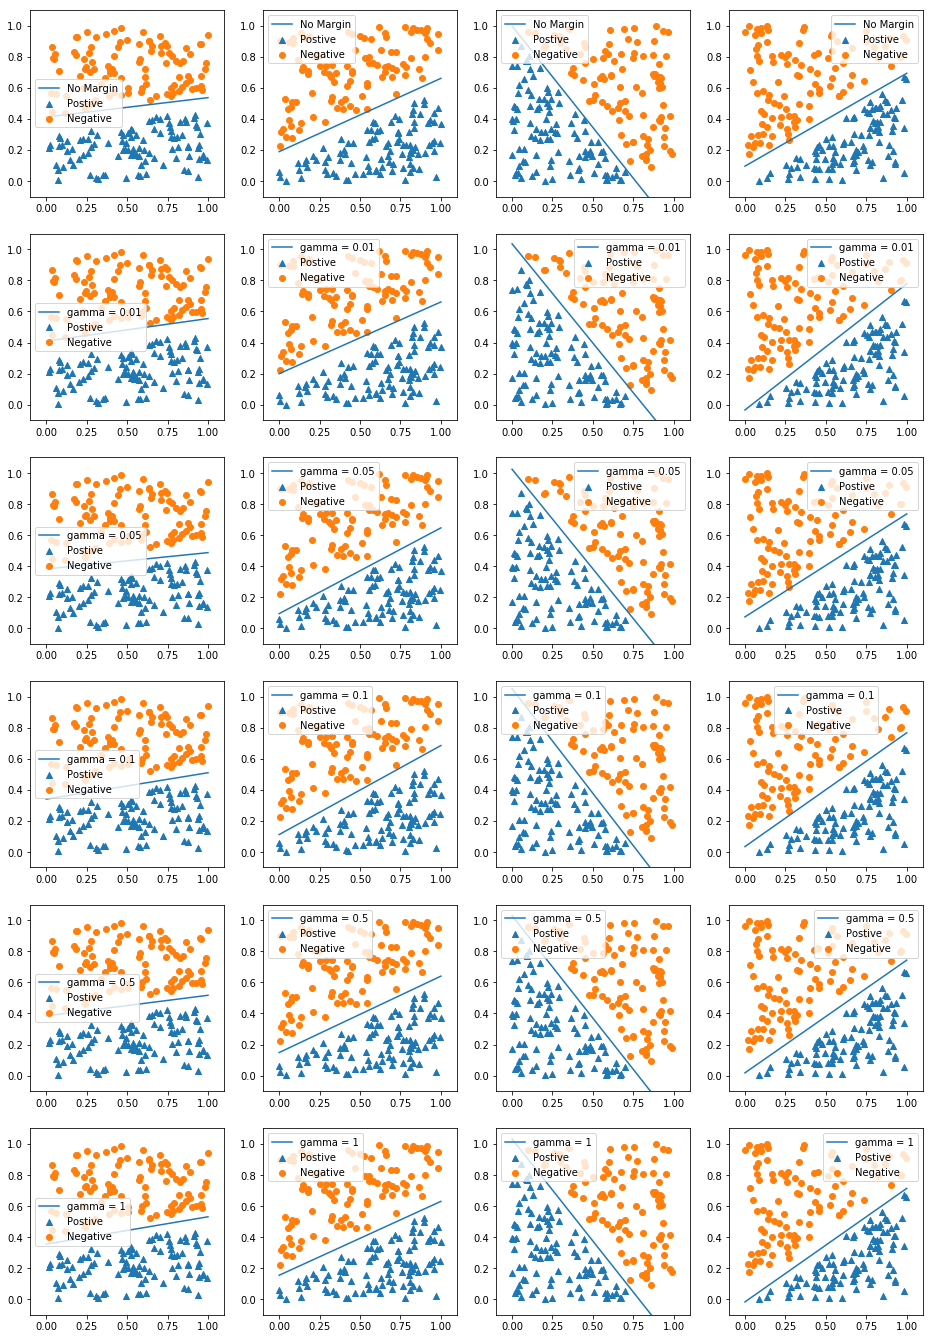

In [5]:
plt.rcParams["figure.figsize"] = [16,24]
fig, ax = plt.subplots(6,4)
for i in range(4):
    X_pos, X_neg, _, _ = gen_data()
    plot = ax[0,i]
    plot.set_xlim(-0.1, 1.1)
    plot.set_ylim(-0.1, 1.1)
    j = 1
    alpha,k = perceptron(X_pos, X_neg)
    vec_scatter(plot, X_pos, mark='^', label='Postive')
    vec_scatter(plot, X_neg, mark='o', label='Negative')
    plot.plot([0, 1], [-alpha[2] / alpha[1], -(alpha[2] + alpha[0]) / alpha[1]], label='No Margin')
    plot.legend()
    for gamma in [0.01,0.05,0.1,0.5,1]:
        plot = ax[j,i]
        alpha,k = perceptron_margin(X_pos, X_neg,gamma)
        plot.plot([0, 1], [-alpha[2] / alpha[1], -(alpha[2] + alpha[0]) / alpha[1]], label='gamma = {}'.format(gamma))
        vec_scatter(plot, X_pos, mark='^', label='Postive')
        vec_scatter(plot, X_neg, mark='o', label='Negative')
        j = j + 1
        plot.set_xlim(-0.1, 1.1)
        plot.set_ylim(-0.1, 1.1)
        plot.legend()

plt.show()

### Analysis on the relaionship between $\gamma$ and the performance of the algorithm

Firstly, we will focus on the iteration times of the algorithm, according to the experiment below, we can get that the greater the $\gamma$ is, the larger iteration loop it will take to terminate the algorithm, which is because that the rules defined by a larger margin $\gamma$ is more strict to fit

In [6]:
K = []
for i in range(100):
    X_pos, X_neg, _, _ = gen_data()
    k_time = []
    
    alpha,k = perceptron(X_pos, X_neg)
    k_time.append(k)

    for gamma in [0.01,0.05,0.1,0.5,1]:
        _,k = perceptron_margin(X_pos, X_neg, gamma)
        k_time.append(k)
    K.append(k_time)
K = np.array(K)
m = np.mean(K,axis = 0)
gamma = [0,0.01,0.05,0.1,0.5,1]
for i in range(6):
    print('gramma = \t{}\taverage iteration time = \t{}'.format(gamma[i],m[i]))

gramma = 	0	average iteration time = 	523.14
gramma = 	0.01	average iteration time = 	595.78
gramma = 	0.05	average iteration time = 	761.32
gramma = 	0.1	average iteration time = 	1263.84
gramma = 	0.5	average iteration time = 	5124.59
gramma = 	1	average iteration time = 	11976.83


### Analysis on the relation of the position of  classifer (hyper)plane

We will draw the position of (hyper)plane for a certain dataset generated by different margin $\gamma$ as the following plot:

From the experiment above, we can find out that the margin of (hyper)plane of classifier is greater with the increasing of $\gramma$,however, when the $\gamma$ is large enough, the position of (hyper)plane will not change any more.

To sum up, the $\gamma$ benefit the classifier to some extent, the value of $\gamma$ should be carefully choosen, otherwise, the algorithm will be too slow or the benefit of $\gamma$ is not fully exploited. In our situation, it is a good idea to choose $\gamma = 0.1 \sim 0.5$

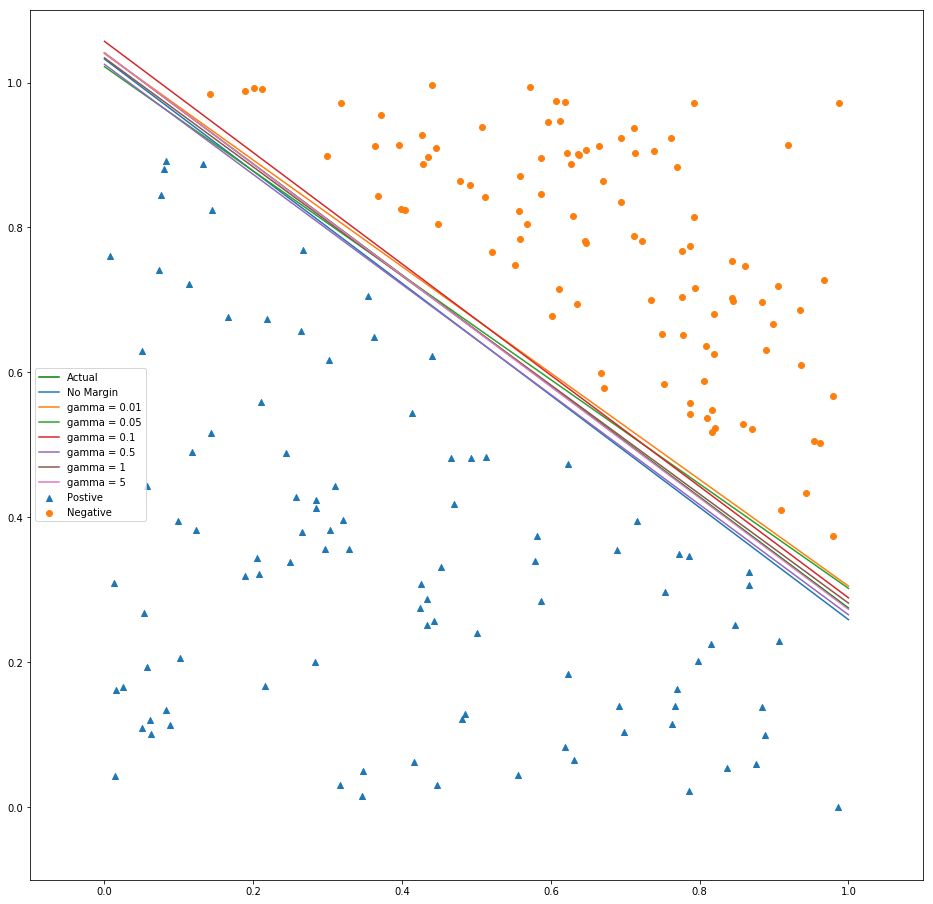

In [7]:
plt.rcParams["figure.figsize"] = [16,16]
X_pos, X_neg, k, b = gen_data()
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
vec_scatter(plt, X_pos, mark='^', label='Postive')
vec_scatter(plt, X_neg, mark='o', label='Negative')
plt.plot([0, 1], [b, k + b],c = 'g', label = 'Actual')
    
alpha,k = perceptron(X_pos, X_neg)
plt.plot([0, 1], [-alpha[2] / alpha[1], -(alpha[2] + alpha[0]) / alpha[1]], label='No Margin')
for gamma in [0.01,0.05,0.1,0.5,1,5]:
    alpha,k = perceptron_margin(X_pos, X_neg,gamma)
    plt.plot([0, 1], [-alpha[2] / alpha[1], -(alpha[2] + alpha[0]) / alpha[1]], label='gamma = {}'.format(gamma))

plt.legend()
plt.show()